In [7]:
# both envs require
import os

In [2]:
import arcpy

In [1]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import fiona
from rasterio.plot import show, show_hist
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
ExtensionName = 'Spatial'
if arcpy.CheckExtension(ExtensionName) == "Available":
        arcpy.CheckOutExtension(ExtensionName)

In [4]:
arcpy.env.workspace = r'T:\Models\StoryMap\UrbanSim\UrbanSim.gdb'
arcpy.env.overwriteOutput = True

In [2]:
path = r'T:\Trans Projects\Model Development\UrbanSim_LandUse\Output\Simulation_47_Final_RTP'

In [3]:
yrbuilt = 2021

In [7]:
def createHeatmap(yrbuilt = 2021, field = "nnsqft"):
    arcpy.FeatureToPoint_management(in_features=os.path.join(path, 'output', 'newDevAnn' + str(yrbuilt) +'.shp'), 
                                out_feature_class="newDevCentroid", point_location="INSIDE")
    arcpy.gp.KernelDensity_sa("newDevCentroid", "nnsqft", 
                          os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + ".tif"),
                          "100","", "SQUARE_KILOMETERS", "DENSITIES", "GEODESIC")

In [4]:
def reprojection(yrbuilt = 2021, field = "nnsqft", dst_crs = 'EPSG:3857'):
    with rasterio.open(os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + ".tif")) as src:
            transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            with rasterio.open(os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_3857.tif"), 
                               'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
    src.close()
    dst.close()

In [5]:
def maskRaster(yrbuilt = 2021, field = "nnsqft", maskFile = "V:/Data/Transportation/MPO_Bound.shp"):
    dataset = rasterio.open(os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_3857.tif"))
    with fiona.open(maskFile, "r") as vectorfile:
        shapes = [feature["geometry"] for feature in vectorfile]
    out_image, out_transform = mask(dataset=dataset, shapes=shapes, crop=True)
    out_meta = dataset.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    file = os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_clipped.tif")
    with rasterio.open(file, "w", **out_meta) as dest:
        dest.write(out_image)
    dataset.close()
    dest.close()

In [8]:
createHeatmap()

In [8]:
reprojection()

In [9]:
maskRaster()

In [10]:
yrbuilt = 2021
field = "nnsqft"
file = os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_clipped.tif")
raster = rasterio.open(file)

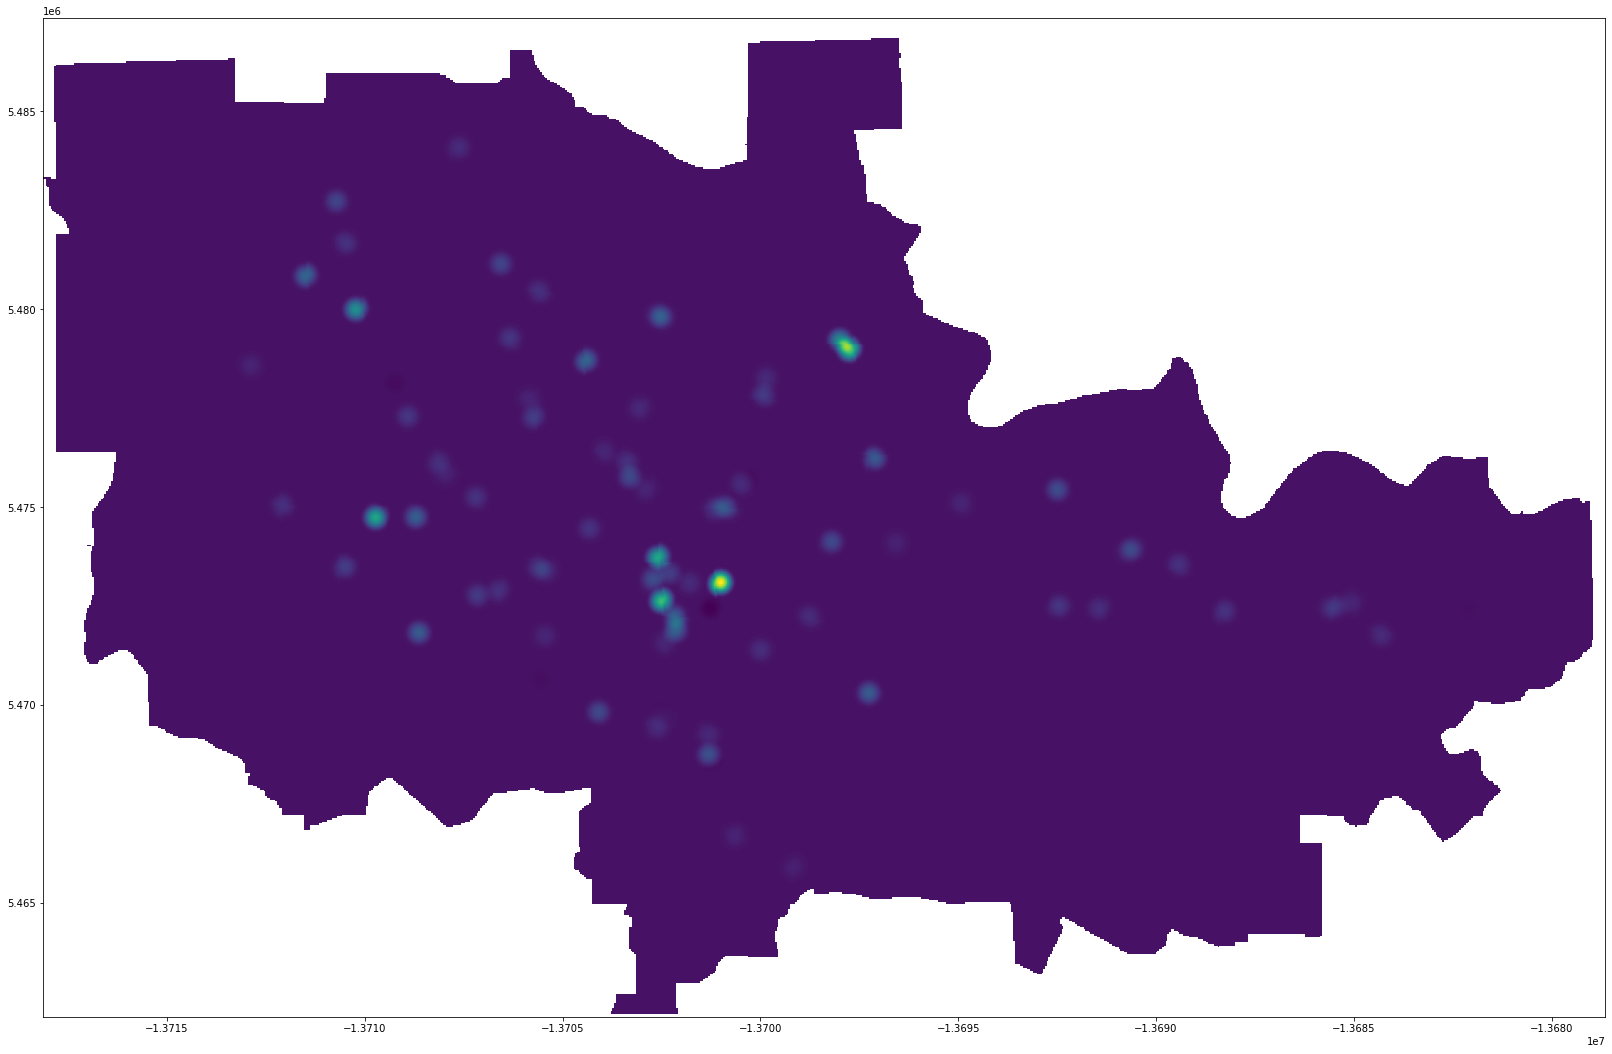

<AxesSubplot:>

In [11]:
fig, ax = plt.subplots(1, figsize=(28, 24))
show(raster)

In [12]:
raster.close()

In [9]:
for yrbuilt in range(2021, 2046, 5):
    createHeatmap(yrbuilt = yrbuilt)
    print("Processed " + str(yrbuilt) + "...")

Processed 2021...
Processed 2026...
Processed 2031...
Processed 2036...
Processed 2041...


In [13]:
for yrbuilt in range(2021, 2046, 5):
    reprojection(yrbuilt = yrbuilt)
    maskRaster(yrbuilt = yrbuilt)
    print("Processed " + str(yrbuilt) + "...")

Processed 2021...
Processed 2026...
Processed 2031...
Processed 2036...
Processed 2041...


In [19]:
outpath = r'T:\Models\StoryMap\UrbanSim'

In [16]:
def plotRaster(yrbuilt = 2021, field = "nnsqft", fieldName = 'New Non-res SQFT', export = True):
    file = os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + "_clipped.tif")
    src = rasterio.open(file, mode="r+")
    fig, ax = plt.subplots(figsize=(28, 24))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    # use imshow so that we have something to map the colorbar to
    image_hidden = ax.imshow(src.read(1), 
                             cmap='PuRd', 
                             vmin=-36000, 
                             vmax=660000)
    # plot on the same axis with rio.plot.show
    image = show(src.read(1), 
                 transform=src.transform, 
                 ax=ax, 
                 cmap='PuRd', 
                 vmin=-36000, 
                 vmax=660000)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, alpha=0.3)
    ax.set_title(fieldName + " Heatmap in Central Lane MPO (" + str(yrbuilt) + ")", fontsize=50, fontname="Palatino Linotype", 
                  color="grey", loc = 'center')
    # add colorbar using the now hidden image
    cbar = fig.colorbar(image_hidden, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=20)
    ax.axis("off");
    if export:
        plt.savefig(os.path.join(outpath, "heatmap" + str(yrbuilt) + ".png"), transparent=True, bbox_inches='tight')
        print("Saved image for " + str(yrbuilt) + "...")

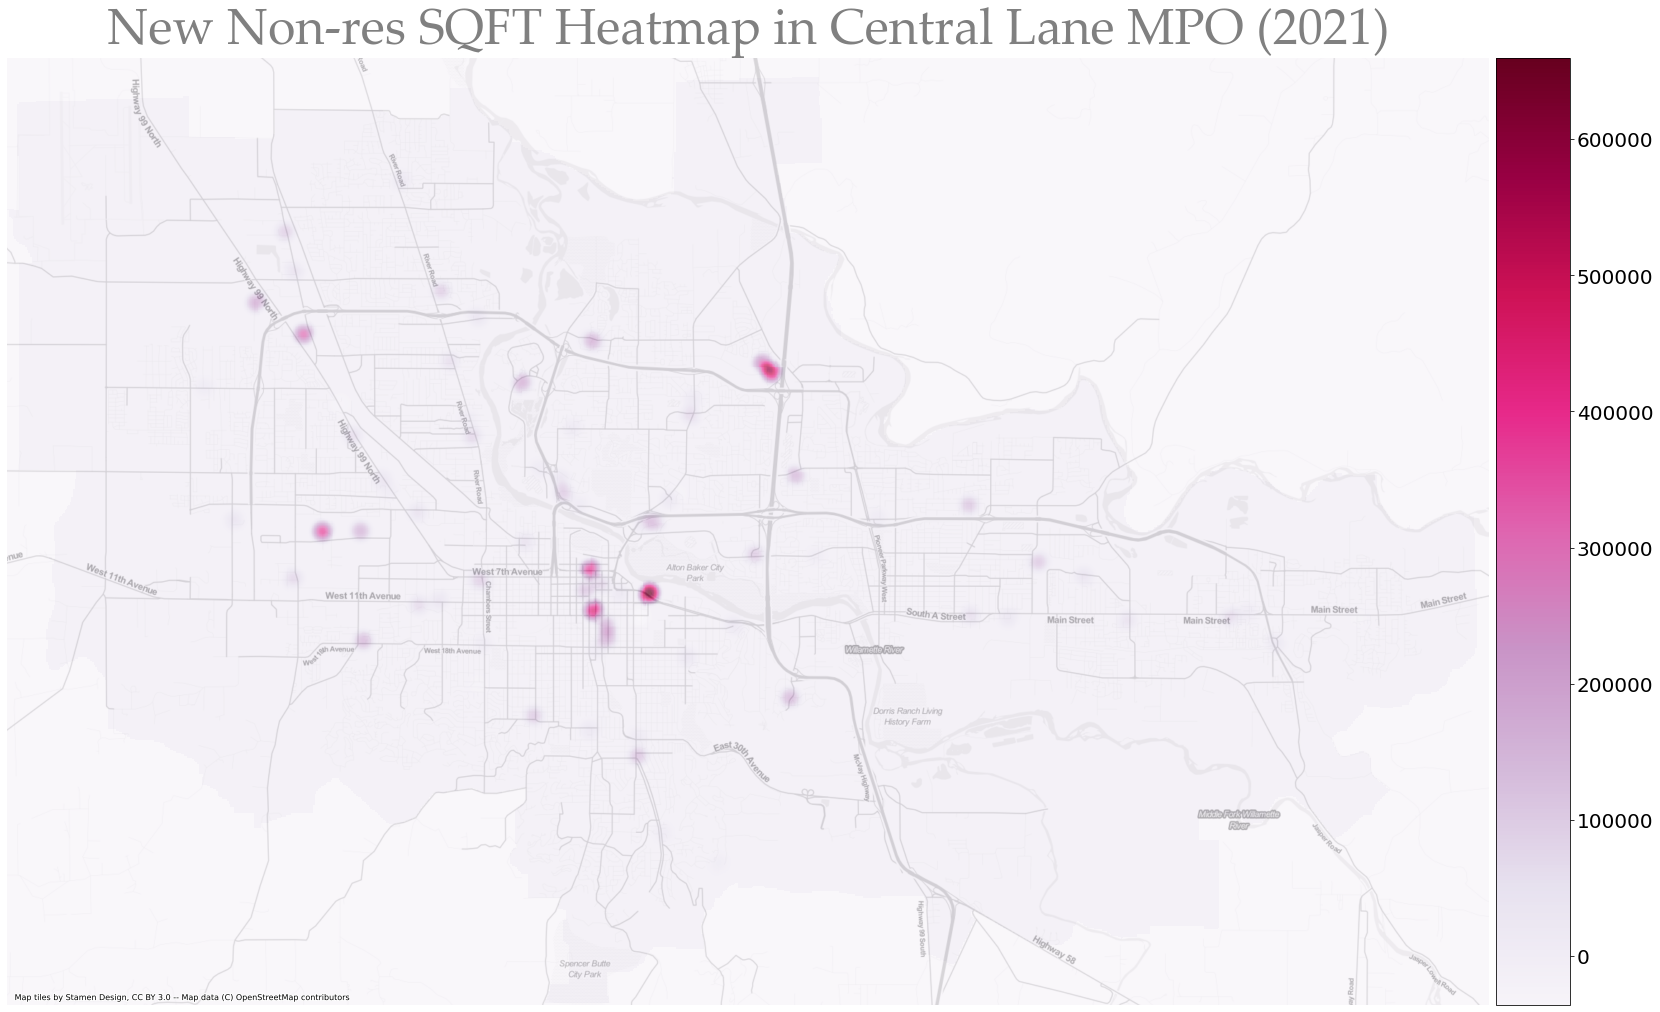

In [17]:
plotRaster(export = False)

Saved image for 2021...
Saved image for 2026...
Saved image for 2031...
Saved image for 2036...
Saved image for 2041...


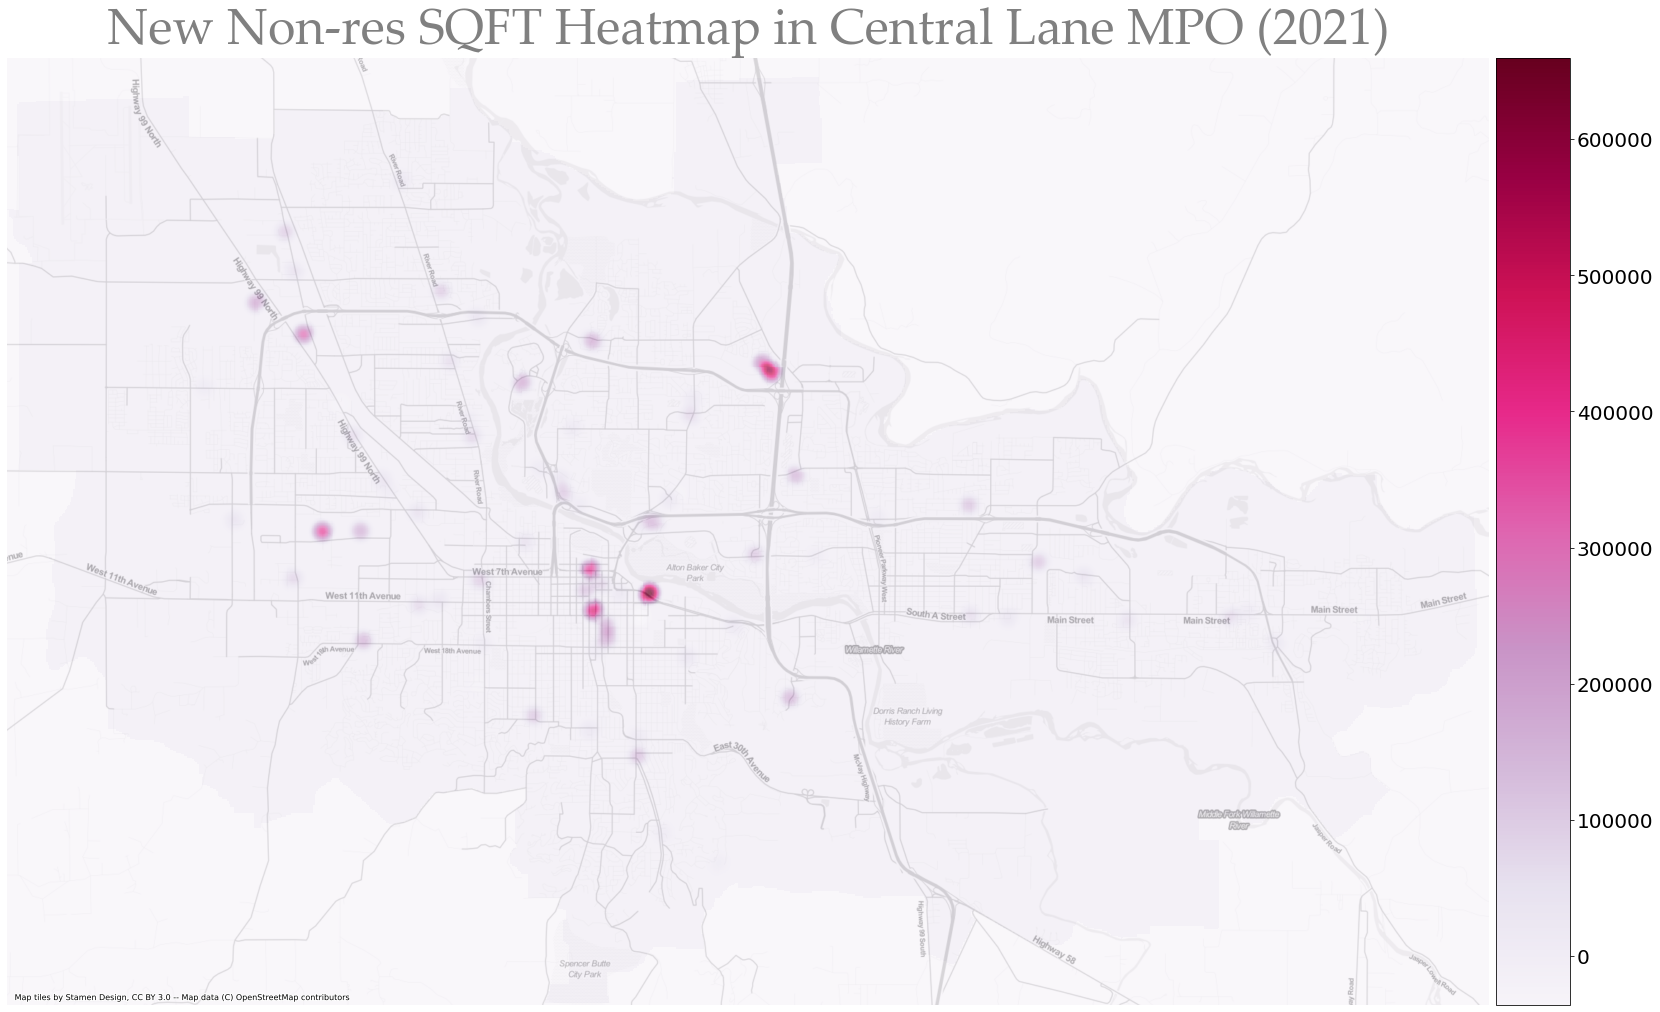

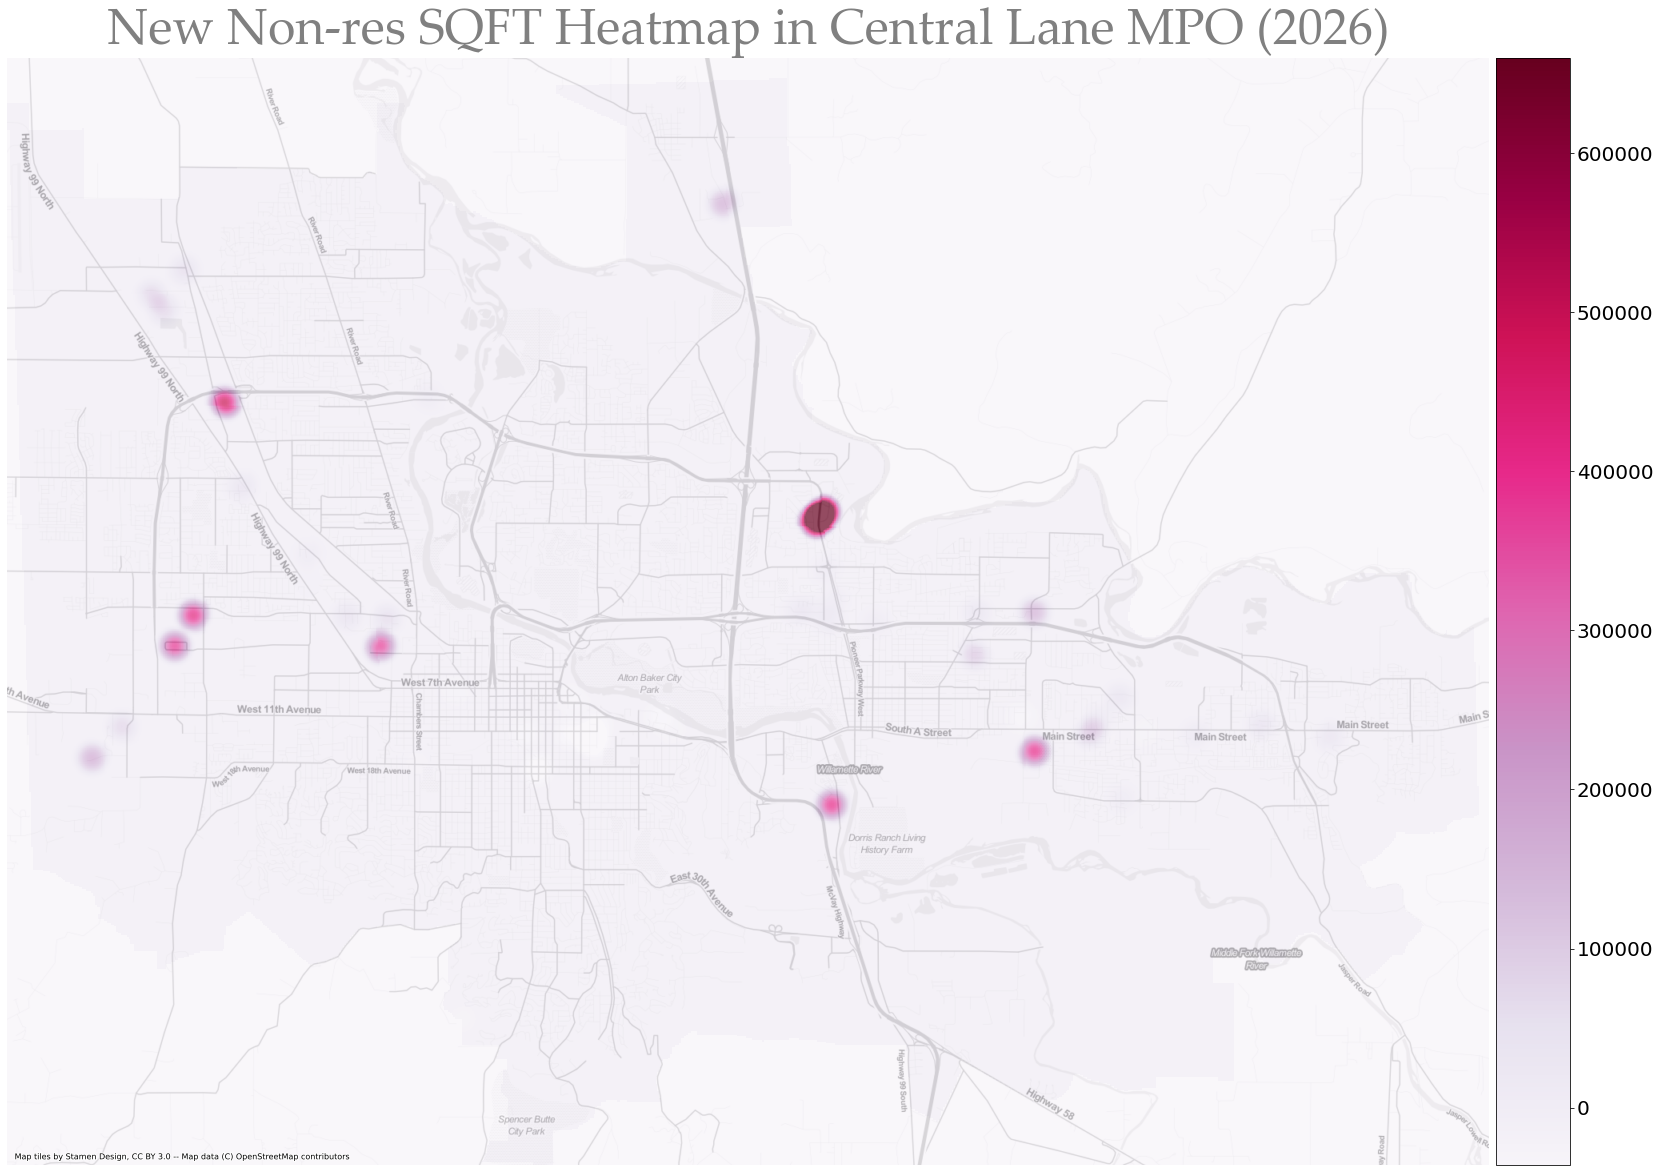

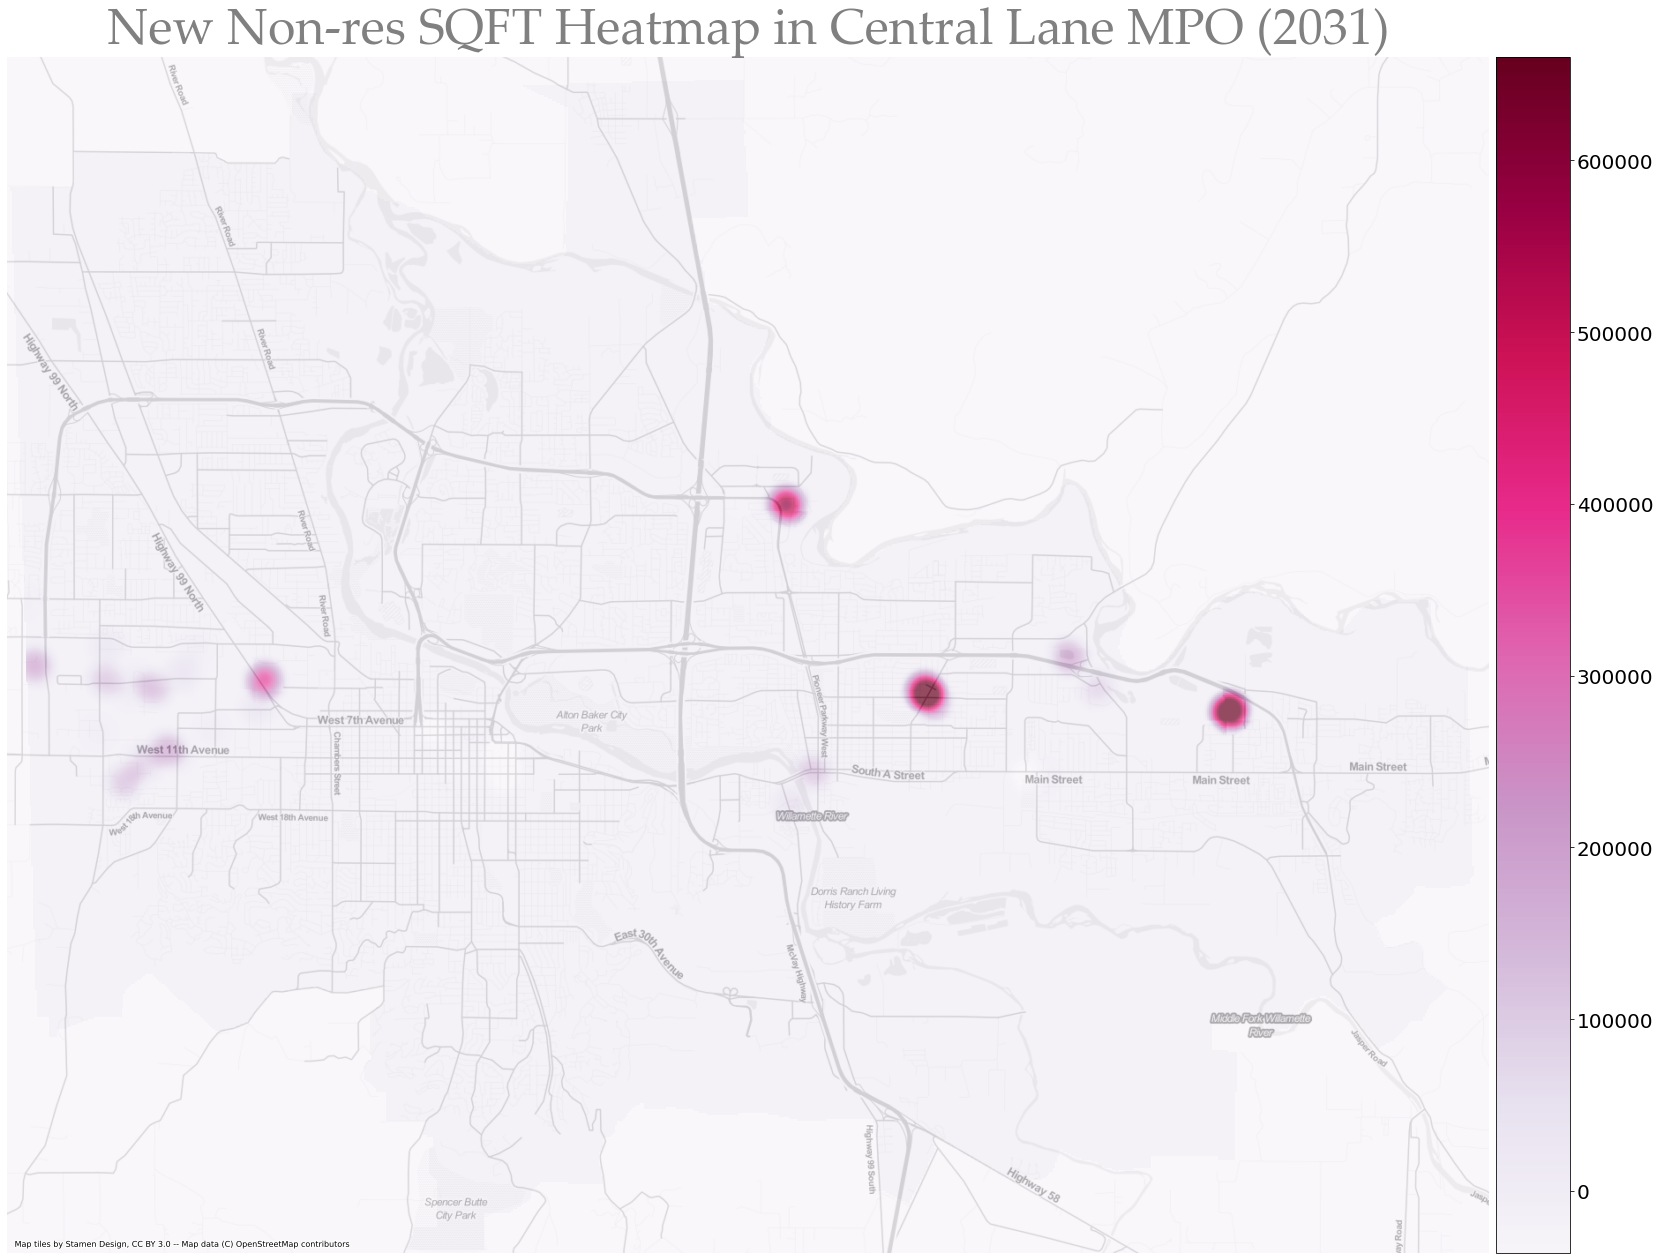

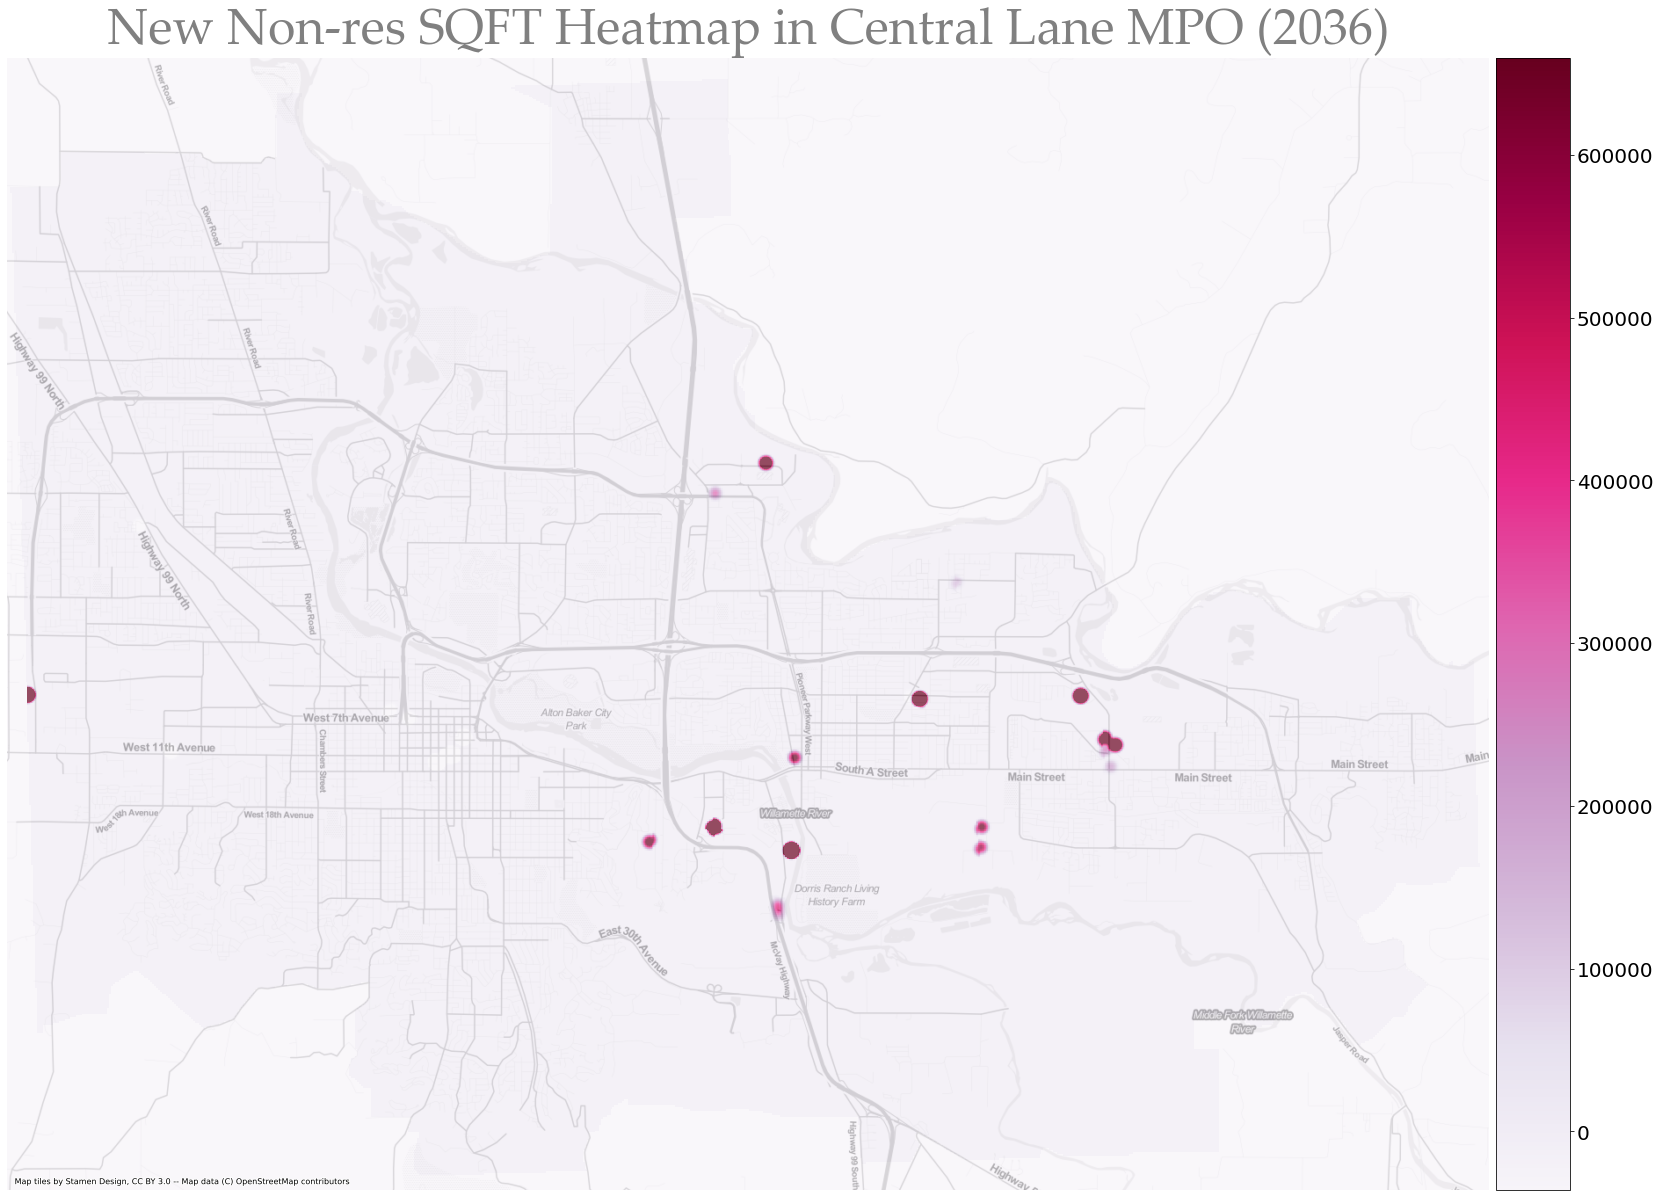

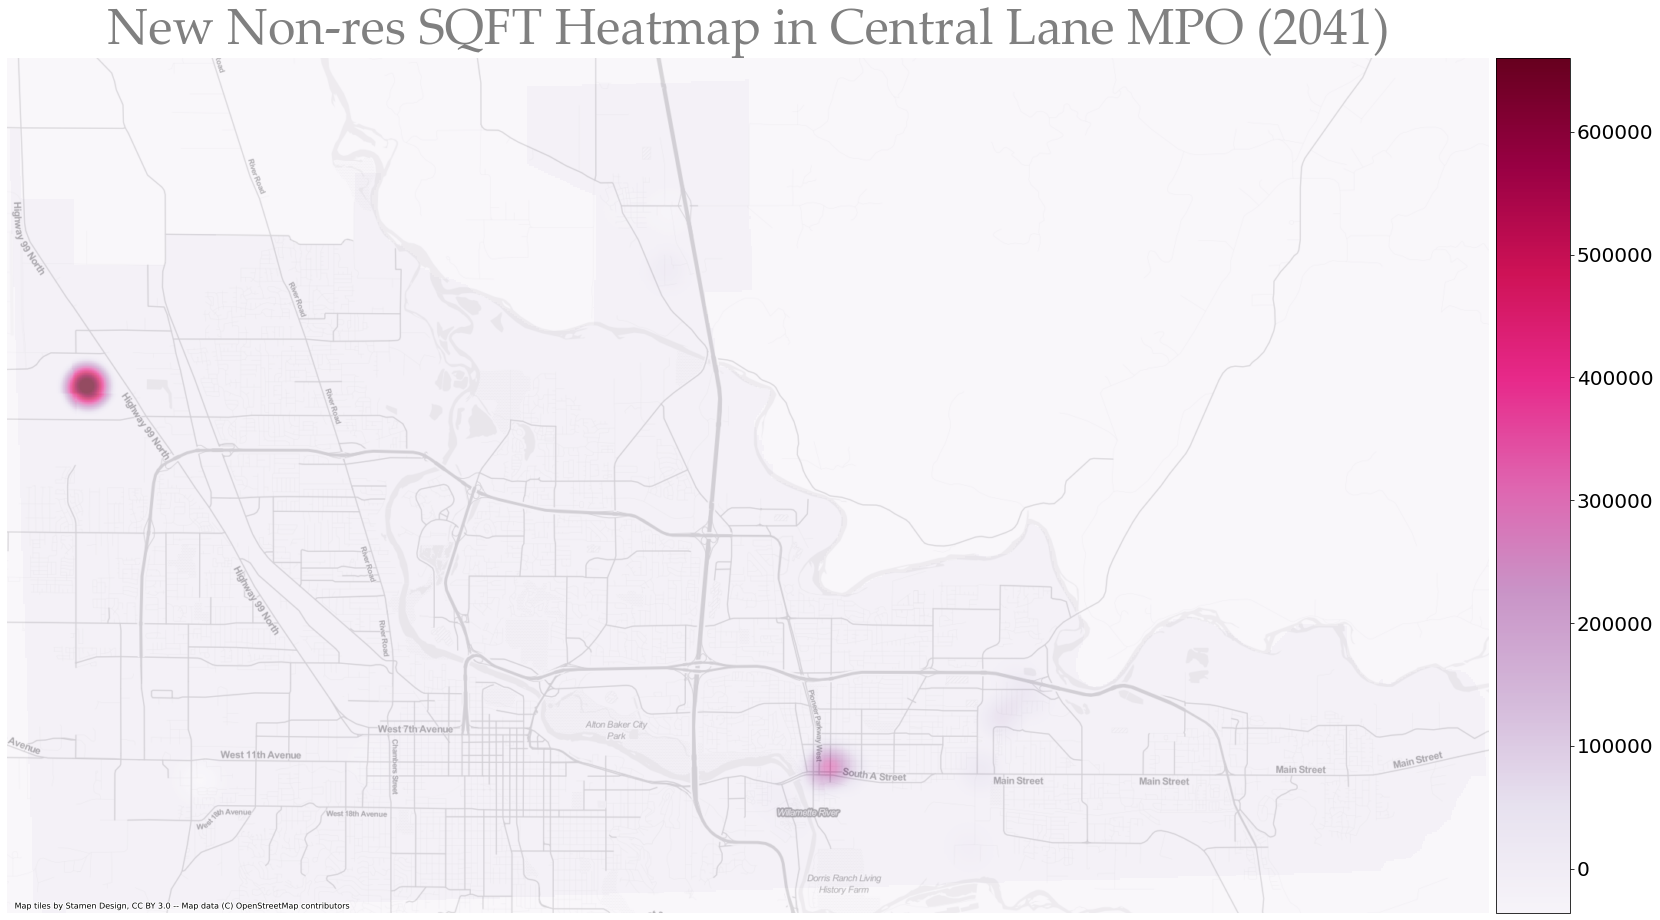

In [21]:
for yrbuilt in range(2021, 2046, 5):
    plotRaster(yrbuilt = yrbuilt)

In [36]:
src.close()